**this will allow to connect with google drive**

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**First step to import the necessary libarary for the sickel cell project "plotly.express" is a Python data visualization library built on top of the plotly library.**

In [21]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications import ResNet50V2
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
!pip install ruptures
import ruptures as rpt
import shutil
import seaborn as sns
import random
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import applications
from tensorflow.keras.optimizers import Adam


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
#!rm -r /content/content/Validation
#!rm -r /content/drive/MyDrive/MDD2/Validation/


**Loading the file Path**

In [22]:
# Create the processed data directory if it does not exist
if not os.path.exists("content/processed_images"):
    os.makedirs("content/processed_images")

**Implementing Histogram to enhance the color contrast of the images**

In [23]:
# Create a CLAHE object with desired parameters
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Loop through all images in the rawdata folder
for file_name in os.listdir("/content/drive/MyDrive/MDD/221025-SCS031 CHP"):
    # Read the image
    img_path = os.path.join("/content/drive/MyDrive/MDD/221025-SCS031 CHP", file_name)
    img = cv2.imread(img_path)

    # Apply CLAHE to the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_clahe = clahe.apply(gray)

   # Convert the processed image to RGB
    img_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

    # Save the processed image in the processed_data folder
    out_path = os.path.join("content/processed_images", file_name)
    cv2.imwrite(out_path, img_rgb)


**Renaming Images because of spliting images into multiple folders cause it works with integer numbers. There might be a way to puse the original label of images but until now couldn't solve it**

In [24]:
# Set the path to the directory containing the image files
img_dir = "content/processed_images"

# Get a list of image filenames sorted alphabetically
img_list = sorted(os.listdir(img_dir))

# Iterate through the list and rename each file
for i, old_name in enumerate(img_list):
    # Generate the new filename with leading zeros
    new_name = f"{i+1:04}.jpg"
    
    # Construct the full paths to the old and new files
    old_path = os.path.join(img_dir, old_name)
    new_path = os.path.join(img_dir, new_name)
    
    # Rename the file
    os.rename(old_path, new_path)

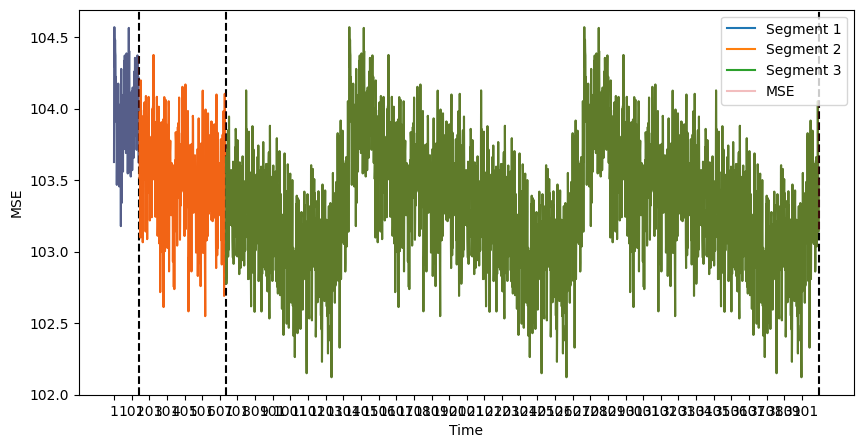

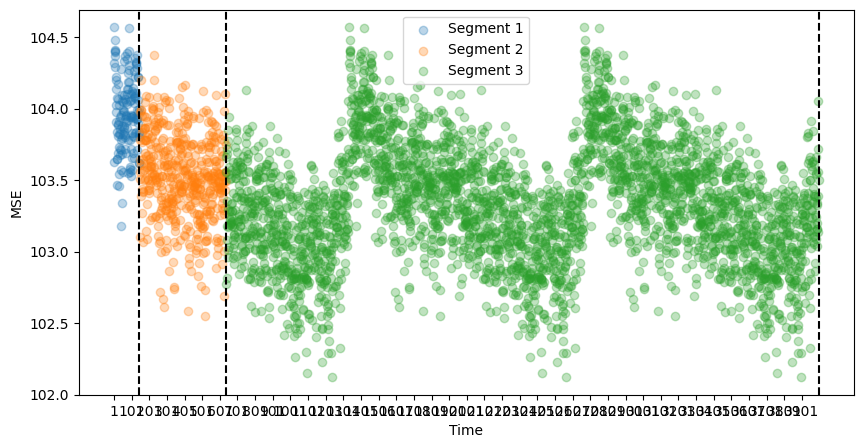

In [25]:
# Load the list of images in the processed_data folder
image_list = os.listdir("content/processed_images")
# Sort the list of images by timestamp
image_list.sort()

# Create an empty list to store the MSE values
mse_values = []

# Loop through pairs of consecutive images and calculate the MSE
for i in range(len(image_list) - 1):
    # Read the two consecutive images
    img_path_1 = os.path.join("content/processed_images", image_list[i])
    img_path_2 = os.path.join("content/processed_images", image_list[i+1])
    img1 = cv2.imread(img_path_1)
    img2 = cv2.imread(img_path_2)
    # Compute the MSE between the two images
    mse = np.mean((img1 - img2)**2)

    # Add the MSE value to the list
    mse_values.append(mse)

# Create a time axis based on the timestamps in the image filenames
time_axis = [int(img.split(".")[0]) for img in image_list[:-1]]

# Run changepoint detection on the MSE values using the Pelt algorithm
model = "rbf"
algo = rpt.Pelt(model=model).fit(np.array(mse_values))
result = algo.predict(pen=10)
num_segments = 3  # number of segments to create
if len(result) >= num_segments:
    result = result[:num_segments-1] + [result[-1]]
else:
    result = [0] * (num_segments - len(result) - 1) + result + [len(mse_values)]
# Plot the segmented time series with changepoints
fig, ax = plt.subplots(figsize=(10, 5))
changepoints = []
for i, rpt_id in enumerate(result):
    if i == 0:
        start = 0
    else:
        start = result[i-1]
    end = result[i]
    ax.plot(time_axis[start:end], mse_values[start:end], label=f"Segment {i+1}")
    ax.axvline(x=time_axis[end-1], color='k', linestyle='--')  # add vertical line at changepoint
    changepoints.append(time_axis[end-1])  # add changepoint to the list
ax.plot(time_axis, mse_values, alpha=0.3, label="MSE")
ax.legend()
plt.xlabel("Time")
plt.ylabel("MSE")
plt.xticks(np.arange(time_axis[0], time_axis[-1], step=100))
plt.show()


#scatter plot
fig, ax = plt.subplots(figsize=(10, 5))
changepoints = []
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
for i, rpt_id in enumerate(result):
    if i == 0:
        start = 0
    else:
        start = result[i-1]
    end = result[i]
    ax.scatter(time_axis[start:end], mse_values[start:end], label=f"Segment {i+1}", alpha=0.3, color=colors[i])
    ax.axvline(x=time_axis[end-1], color='k', linestyle='--')  # add vertical line at changepoint
    changepoints.append(time_axis[end-1])  # add changepoint to the list
ax.legend()
plt.xlabel("Time")
plt.ylabel("MSE")
plt.xticks(np.arange(time_axis[0], time_axis[-1], step=100))
plt.show()


**Copying and moving images to 3 classes according to the peak deformability that we got from the graph**

In [26]:

# Create directories for the 5 classes
class1_dir = "/content/drive/MyDrive/MDD2/Train/Phase1"
class2_dir = "/content/drive/MyDrive/MDD2/Train/Phase2"
class3_dir = "/content/drive/MyDrive/MDD2/Train/Phase3"

os.makedirs(class1_dir, exist_ok=True)
os.makedirs(class2_dir, exist_ok=True)
os.makedirs(class3_dir, exist_ok=True)

# Copy images to the appropriate class directories based on the changepoints
for i, rpt_id in enumerate(result):
    if i == 0:
        start = 0
    else:
        start = result[i-1]
    end = result[i]
    
    if i == 0:
        class_dir = class1_dir
    elif i == 1:
        class_dir = class2_dir
    else :
        class_dir = class3_dir
    
    for j in range(start, end):
        old_path = os.path.join("content/processed_images", f"{time_axis[j]:04}.jpg")
        new_path = os.path.join(class_dir, f"{time_axis[j]:04}.jpg")
        shutil.copy(old_path, new_path)

Now we are going to split 20% of images to test and validation folders randomly

In [27]:
# Define directories for train, validation, and test folders
train_dir = "/content/drive/MyDrive/MDD2/Train"
val_dir = "/content/drive/MyDrive/MDD2/Validation"
test_dir = "/content/drive/MyDrive/MDD2/Test"
classes = ["Phase1", "Phase2", "Phase3"]

# Create directories for the 5 classes in train, validation, and test folders
for dir_path in [train_dir, val_dir, test_dir]:
    for class_name in classes:
        os.makedirs(os.path.join(dir_path, class_name), exist_ok=True)

# Move 20% of images from each class directory in train folder to validation and test folders
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    image_list = os.listdir(class_dir)
    num_images = len(image_list)
    num_val_images = int(num_images * 0.2)
    val_image_list = random.sample(image_list, num_val_images)
    test_image_list = random.sample(list(set(image_list) - set(val_image_list)), num_val_images)
    for img in val_image_list:
        old_path = os.path.join(class_dir, img)
        new_path = os.path.join(val_class_dir, img)
        shutil.move(old_path, new_path)
    for img in test_image_list:
        old_path = os.path.join(class_dir, img)
        new_path = os.path.join(test_class_dir, img)
        shutil.move(old_path, new_path)



In [28]:
train_dir = '/content/drive/MyDrive/MDD2/Train'
test_dir = '/content/drive/MyDrive/MDD2/Test'
validation_dir = '/content/drive/MyDrive/MDD2/Validation'





# Training with VGG16 pretrained Model


**Compiling the model and Applied Data Augmentation Techniques**

In [29]:
# Dimensions of our images.
img_width, img_height = 224, 224


# Number of samples per batch.
batch_size = 32

# Use the VGG16 model with pre-trained weights
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add new layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Freeze the VGG16 model weights
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Training the model**

In [30]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))


Found 2397 images belonging to 3 classes.
Found 799 images belonging to 3 classes.
Found 799 images belonging to 3 classes.
Epoch 1/30
75/75 [==============================] - 245s 3s/step - loss: 0.8765 - accuracy: 0.8139 - val_loss: 0.4223 - val_accuracy: 0.8411
Epoch 2/30
75/75 [==============================] - 200s 3s/step - loss: 0.5058 - accuracy: 0.8406 - val_loss: 0.4468 - val_accuracy: 0.8411
Epoch 3/30
75/75 [==============================] - 234s 3s/step - loss: 0.4813 - accuracy: 0.8411 - val_loss: 0.4324 - val_accuracy: 0.8411
Epoch 4/30
75/75 [==============================] - 195s 3s/step - loss: 0.4730 - accuracy: 0.8411 - val_loss: 0.4183 - val_accuracy: 0.8411
Epoch 5/30
75/75 [==============================] - 235s 3s/step - loss: 0.4538 - accuracy: 0.8411 - val_loss: 0.4183 - val_accuracy: 0.8411
Epoch 6/30
75/75 [==============================] - 197s 3s/step - loss: 0.4593 - accuracy: 0.8411 - val_loss: 0.4228 - val_accuracy: 0.8411
Epoch 7/30
75/75 [============

**Model Evaluation**

In [31]:
# Evaluate the model on the test set
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps_per_epoch)
print('Test accuracy:', test_acc)

25/25 [==============================] - 44s 2s/step - loss: 0.4235 - accuracy: 0.8411
Test accuracy: 0.8410513401031494


**Confusion Matrix**

25/25 [==============================] - 40s 2s/step
[[  0   0  29]
 [  0   0  98]
 [  0   0 672]]


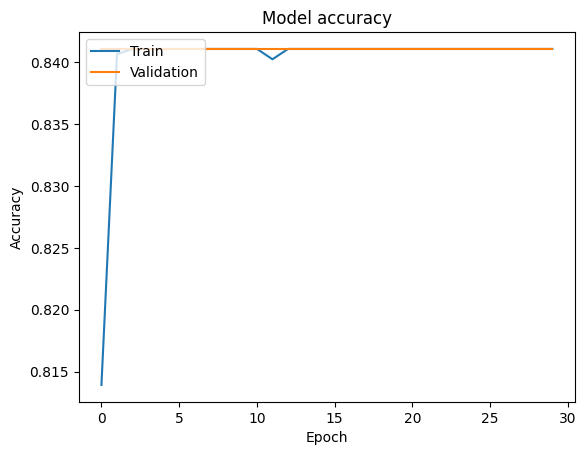

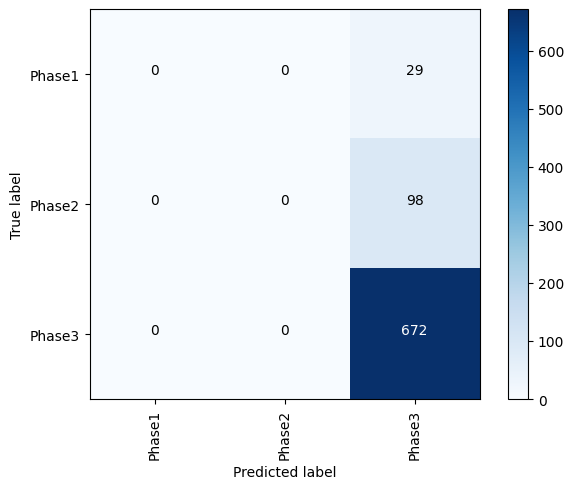

In [32]:
# Compute the confusion matrix
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=-1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=90)
plt.yticks(tick_marks, test_generator.class_indices)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

